In [1]:
from PIL import Image
import numpy as np
import os
import glob
import re
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
%matplotlib inline

datafolder = os.path.join("Data","Versuch_Kugel")
imagefolder = "Bilder_2"
#imagefolder = "Bilder"
imagefolder = os.path.join(datafolder,imagefolder)
r = "rot.txt"
g = "grün.txt"
blu = "blau.txt"

# in m
LAMBDA = 510e-9
Pixelgroesse = 45e-7
#Pixelfläche in m²
A = Pixelgroesse **2

N = 1600
M = 1200

KALIBIRERFAKTOR = 3.166e-10
KMAX_SKOTOPISCH = 1699

Bilder einlesen und in schwarz, weiß und offsetbild aufteilen

In [2]:
def get_imgs(folder,endswith = "*.png",pattern=""):
    return glob.glob(os.path.join(folder,pattern+endswith))


weiss = get_imgs(imagefolder,pattern="Hell")
schwarz = get_imgs(imagefolder,pattern="Dunkel")
offset = get_imgs(imagefolder,pattern="*Offset")

print("Anzahl Bilder : \n\n weiß: {}\tschwarz: {}\toffset: {}".format(len(weiss),len(schwarz),len(offset)))

Anzahl Bilder : 

 weiß: 24	schwarz: 24	offset: 2


Bildernamen nach ihrere Belichtungszeit ordnen/zuweisen (sowie Nr)

In [3]:
regex = r"T_([0-9]+_[0-9]+)_Nr([0-9]+).png"
def get_T_NR(img_path):
    matches = re.search(regex, img_path, re.DOTALL)
    if matches:
        T = int(matches[1])
        NR = int(matches[2])
        return T,NR
    print("INCONSISTENT NAMING: ",img_path)
    return None,None
        
#Images NR1
img_weiss_1 = []
img_schwarz_1 = []

#Images NR2
img_schwarz_2 = []
img_weiss_2 = []

Bilder = {1:{'w':img_weiss_1,
             's':img_schwarz_1},
          2:{'w':img_weiss_2,
             's':img_schwarz_2}}

for w,s in zip(weiss,schwarz):
        T,NR = get_T_NR(w)
        Bilder[NR]['w'].append((w,T))
        T,NR = get_T_NR(s)
        if T is None:
            continue
        Bilder[NR]['s'].append((s,T))
        
img_weiss_1 = sorted(img_weiss_1, key=lambda x: x[1])
img_weiss_2 = sorted(img_weiss_2, key=lambda x: x[1])
img_schwarz_1 = sorted(img_schwarz_1, key=lambda x: x[1])
img_schwarz_2 = sorted(img_schwarz_2, key=lambda x: x[1])
print(len(img_weiss_1))
print(len(img_weiss_2))
print(len(img_schwarz_1))
print(len(img_schwarz_2))
Belichtungszeit = [i[1] for i in img_weiss_1]
Belichtungszeit = np.array(Belichtungszeit)
print(Belichtungszeit)

12
12
12
12
[  2  22  42  62  82 102 122 142 162 182 202 222]


Textdatein des Spektrometers einlesen

In [4]:
def genfromtxt(path,skip = 13):
    csv = []
    with open(path,'r') as f:
        line = f.readline()
        cnt = 1
        while cnt < skip:
            line = f.readline()
            cnt += 1
        while line:
            line = f.readline()
            if "\t" in line:
                x,y = line.split("\t")
            else:
                line = f.readline()
                continue
            x = float(x.replace(",","."))
            y = float(y.replace(",","."))
            csv.append( [x,y] )
            cnt +=1
            
    return np.array(csv)


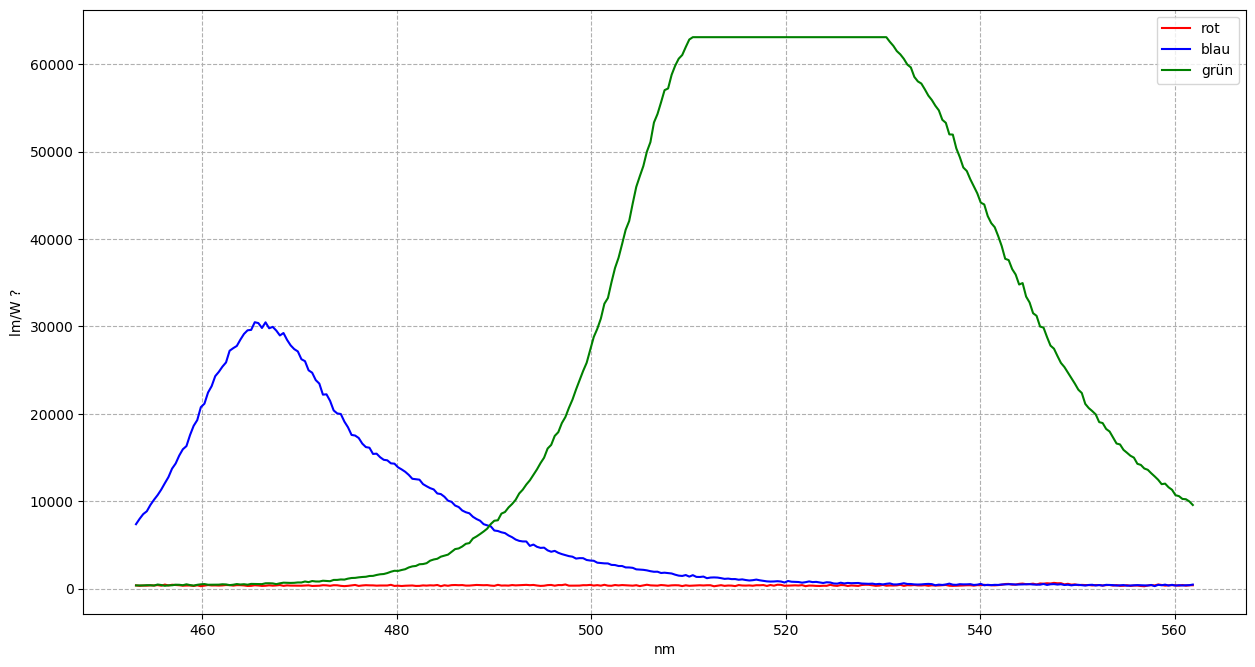

Max grün                 :  63102.32
Beleuchtungsstärke in Lux:  1.9978194512e-05
Bestrahlungsstärke       :  0.043486671832717476


In [5]:
red   = genfromtxt(os.path.join(datafolder,r))
green = genfromtxt(os.path.join(datafolder,g))
blue  = genfromtxt(os.path.join(datafolder,blu))

plt.figure(figsize=(15,8),dpi=100,facecolor='w', edgecolor='k')
plt.plot(red[300:600,0],red[300:600,1],color='red',label="rot")
plt.plot(blue[300:600,0],blue[300:600,1],color='blue',label="blau")
plt.plot(green[300:600,0],green[300:600,1],color='green',label="grün")
plt.legend(loc='upper right')
plt.xlabel("nm")
plt.ylabel("lm/W ?")
plt.grid(linestyle="--")
plt.show()


MESSWERT_GRUEN = green.max()
B_LUX = MESSWERT_GRUEN * KALIBIRERFAKTOR
BESTRAHLUNGSSTARKE = B_LUX  / (KMAX_SKOTOPISCH * 520e-6**2)
print("Max grün                 : ",MESSWERT_GRUEN)
print("Beleuchtungsstärke in Lux: ",B_LUX)
print("Bestrahlungsstärke       : ",BESTRAHLUNGSSTARKE)



### a)

Messen Sie die Bestrahlungsstärke $E$ der Lichtquelle in $\frac{W}{m^2}$ mit dem Photometer in gleichem Abstand wie die Kamera. Achten Sie dabei auf den korrekten Umrechnungs-faktor für die Wellenlänge der Leuchtdiode. Mit der Pixelfläche $A$, der Wellenlänge $λ$ der Leuchtdiode und der Belichtungszeit können Sie so die mittlere Anzahl dereinfallenden Photonen berechnen (s. Vorl.2/5).


### Antwort:

Kalibrierschein für $λ = 510 nm \Rightarrow 0,2927 \frac{A}{W}$

Fläche des Photometersensors = $0.007m^2$

Gemessen mit Photometer: $43,91 *10^{-6} A$

$\Rightarrow \frac{43,91\cdot 10^{-6} A }{0,2927 \frac{A}{W} * (0,007m)^2} = 3,06 \frac{W}{m^2}$

In [6]:
E = 43.91e-6 / (0.007**2 * 0.2927)
print("E = {:.2f}".format(E))

E = 3.06


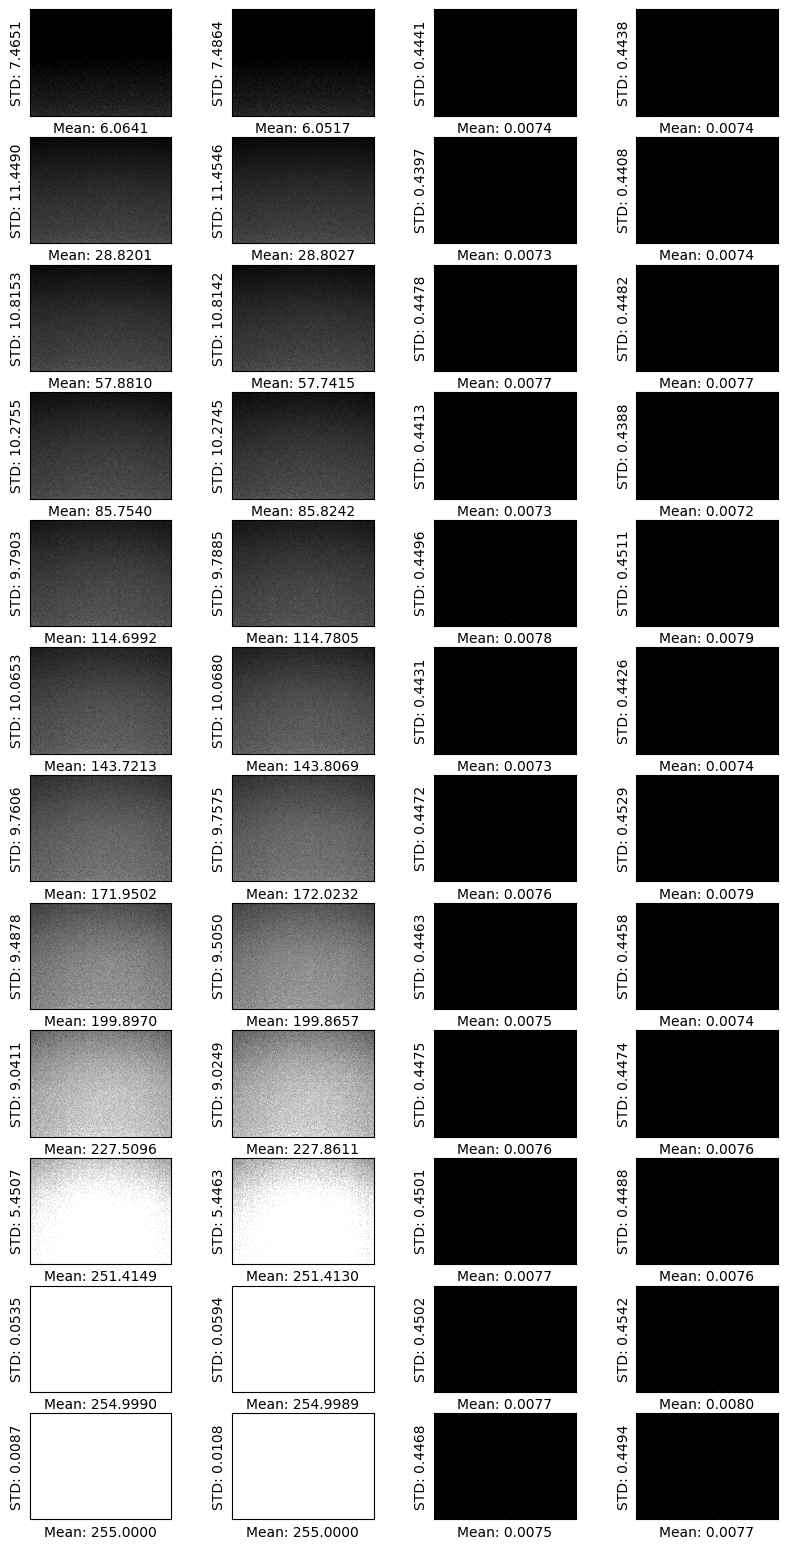

In [7]:
def mittlerergauwert(img_1,img_2):
    mw = []
    std = []
    for img1,img2 in zip(img_1,img_2):
        i1 = np.array(Image.open(img1[0]),dtype=np.int32)
        i2 = np.array(Image.open(img2[0]),dtype=np.int32)
        mw.append((1/(2*N*M)) * (((i1+i2).sum())))
        std.append((1/(2*N*M)) * (((i1-i2)**2).sum() ))
    return np.array(mw),np.array(std)

fig, axes = plt.subplots(len(img_weiss_2),4, figsize=(10, 20),dpi=100, sharex=False, sharey=False)

for i in range(len(img_weiss_1)):
    w1 = np.array(Image.open(img_weiss_1[i][0]))
    w2 = np.array(Image.open(img_weiss_2[i][0]))
    s1 = np.array(Image.open(img_schwarz_1[i][0]))
    s2 = np.array(Image.open(img_schwarz_2[i][0]))
    axes[i,0].imshow(w1,cmap="gray")
    axes[i,0].set_xticks([])
    axes[i,0].set_yticks([])
    axes[i,0].set_xlabel("Mean: {:.4f}".format(w1.mean()))
    axes[i,0].set_ylabel("STD: {:.4f}".format(w1.std()))
    axes[i,1].imshow(w2,cmap="gray")
    axes[i,1].set_xticks([])
    axes[i,1].set_yticks([])
    axes[i,1].set_xlabel("Mean: {:.4f}".format(w2.mean()))
    axes[i,1].set_ylabel("STD: {:.4f}".format(w2.std()))
    axes[i,2].imshow(s1,cmap="gray")
    axes[i,2].set_xticks([])
    axes[i,2].set_yticks([])
    axes[i,2].set_xlabel("Mean: {:.4f}".format(s1.mean()))
    axes[i,2].set_ylabel("STD: {:.4f}".format(s1.std()))
    axes[i,3].imshow(s2,cmap="gray")
    axes[i,3].set_xticks([])
    axes[i,3].set_yticks([])
    axes[i,3].set_xlabel("Mean: {:.4f}".format(s2.mean()))
    axes[i,3].set_ylabel("STD: {:.4f}".format(s2.std()))
    i+=1
plt.show()


def regression(x,y):
    slope, intercept, r_value, p_value, std_err= stats.linregress(x,y)
    return slope,intercept


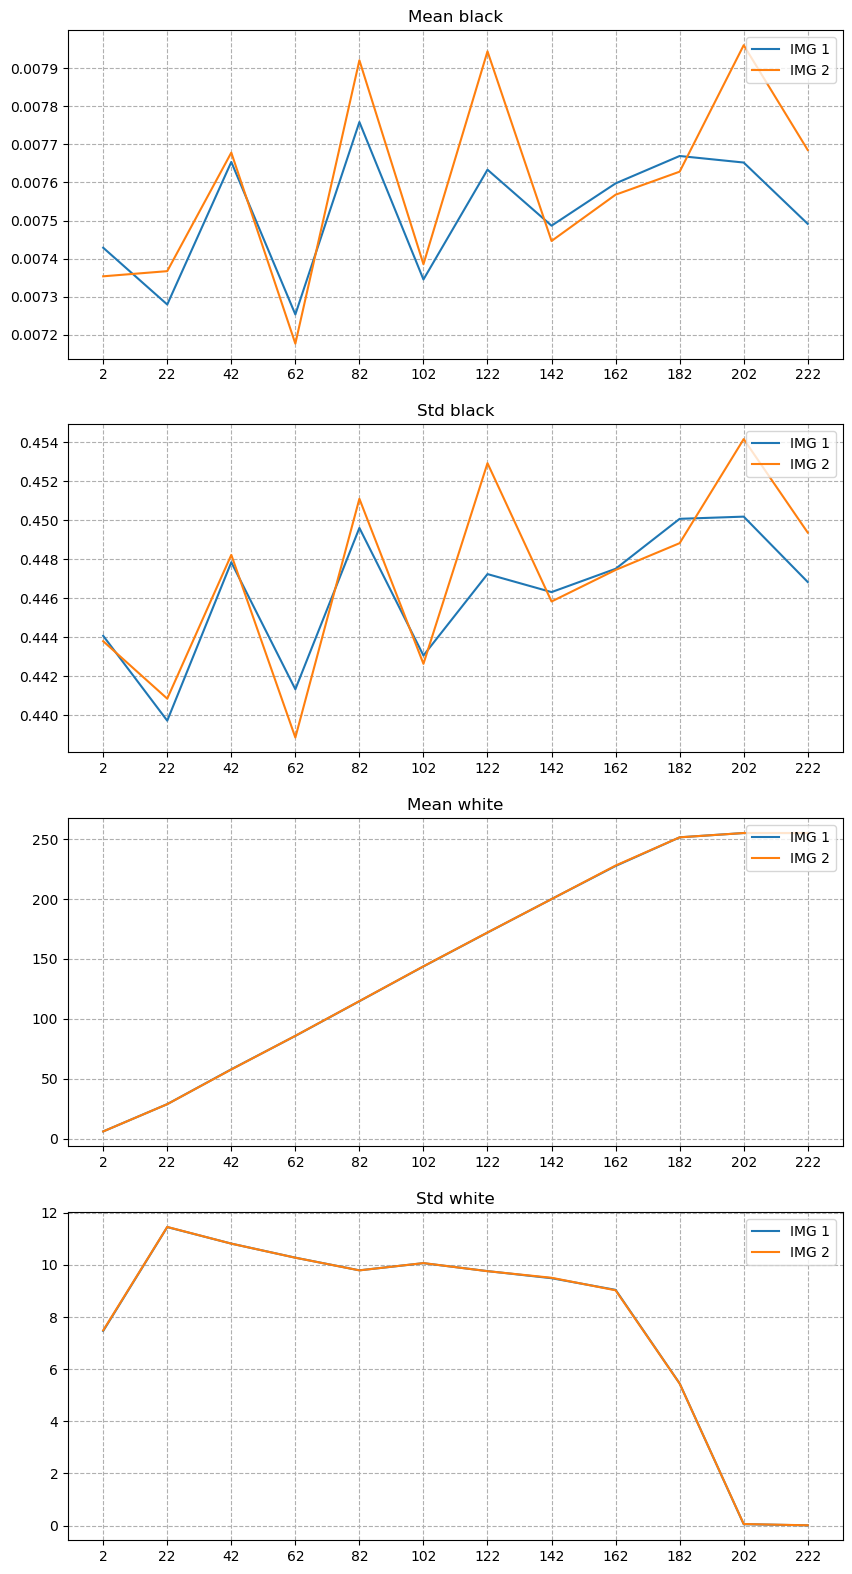

In [8]:
x_s1_mean = []
x_s2_mean = []

x_s1_std = []
x_s2_std = []

x_w1_mean = []
x_w2_mean = []

x_w1_std = []
x_w2_std = []


for i in range(len(img_weiss_1)):
    w1 = np.array(Image.open(img_weiss_1[i][0]))
    w2 = np.array(Image.open(img_weiss_2[i][0]))
    s1 = np.array(Image.open(img_schwarz_1[i][0]))
    s2 = np.array(Image.open(img_schwarz_2[i][0]))
        
    x_s1_std.append(s1.std())
    x_s2_std.append(s2.std())
    
    x_s1_mean.append(s1.mean())
    x_s2_mean.append(s2.mean())
    
    
    x_w1_std.append(w1.std())
    x_w2_std.append(w2.std())
    
    x_w1_mean.append(w1.mean())
    x_w2_mean.append(w2.mean())

fig, axes = plt.subplots(4,1, figsize=(10, 20),dpi=100, sharex=False, sharey=False)
    
axes[0].plot(Belichtungszeit,x_s1_mean,label="IMG 1")
axes[0].plot(Belichtungszeit,x_s2_mean,label="IMG 2")
axes[0].set_title("Mean black")
axes[0].set_xticks(Belichtungszeit)
axes[0].grid(linestyle="--")
axes[0].legend(loc='upper right')
axes[1].plot(Belichtungszeit,x_s1_std,label="IMG 1")
axes[1].plot(Belichtungszeit,x_s2_std,label="IMG 2")
axes[1].set_title("Std black")
axes[1].set_xticks(Belichtungszeit)
axes[1].grid(linestyle="--")
axes[1].legend(loc='upper right')
axes[2].plot(Belichtungszeit,x_w1_mean,label="IMG 1")
axes[2].plot(Belichtungszeit,x_w2_mean,label="IMG 2")
axes[2].set_title("Mean white")
axes[2].set_xticks(Belichtungszeit)
axes[2].grid(linestyle="--")
axes[2].legend(loc='upper right')
axes[3].plot(Belichtungszeit,x_w1_std,label="IMG 1")
axes[3].plot(Belichtungszeit,x_w2_std,label="IMG 2")
axes[3].set_title("Std white")
axes[3].set_xticks(Belichtungszeit)
axes[3].grid(linestyle="--")
axes[3].legend(loc='upper right')
plt.show()


### b) 

Bestimmen Sie den Sättigungspunkt der Kamera, d.h. die maximaleBelichtungszeit, ab der die Pixelvarianz wieder abzunehmen beginnt

Sättigungspunkt bestimmen: 

Maximum des Photonentransfers -jenseits dieses Punktes fällt die Varianz, da die Pixel in Sättigunggehen

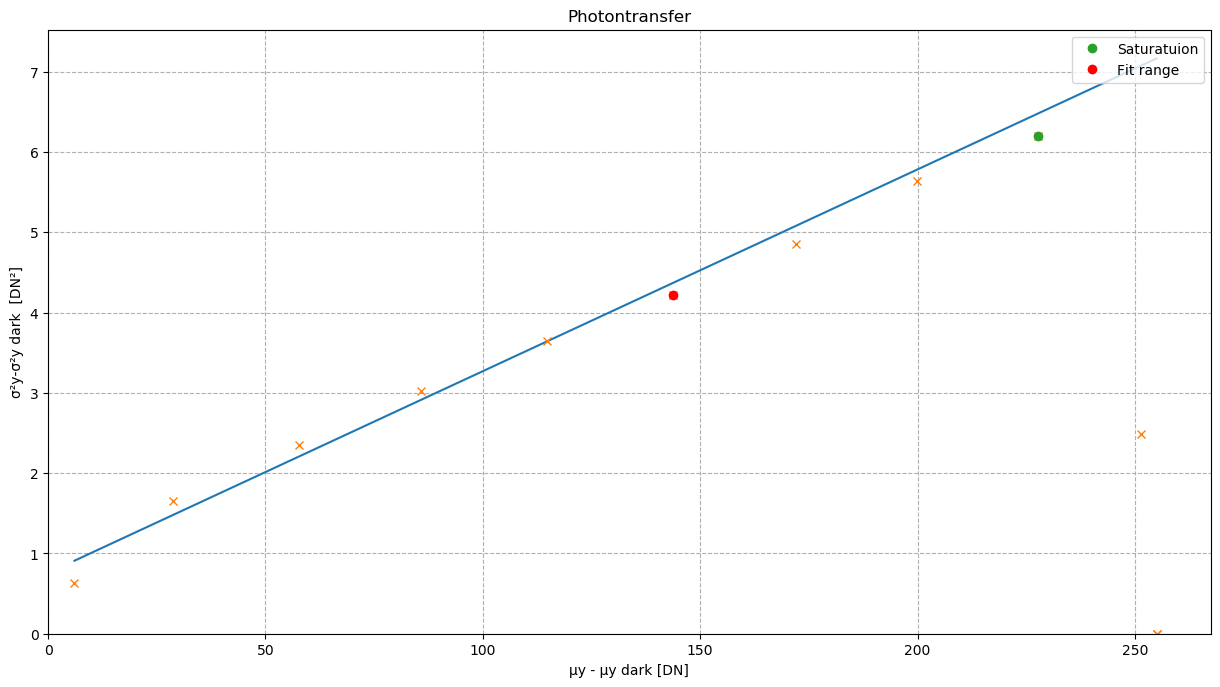

Sättigungspunkt: 6.1941 | 162 ms
K              : 0.0251


In [9]:
mg_schwa,zr_schwa = mittlerergauwert(img_schwarz_1,img_schwarz_2)
mg_weiss,zr_weiss = mittlerergauwert(img_weiss_1,img_weiss_2)

x = np.arange(len(mg_schwa))
diff = zr_weiss-zr_schwa
mg_diff = mg_weiss - mg_schwa
Saettigungspunkt = diff.max()


# 70 % der Sättigung 
i_p = np.where(diff == Saettigungspunkt)[0]
i = np.where(diff[:int(i_p) ] <= 0.7 * Saettigungspunkt)

"""
K,b_K = regression(np.arange(len(i[0])),diff[i])


plt.figure(figsize=(15,8),dpi=100,facecolor='w', edgecolor='k')
plt.plot(Belichtungszeit,b_K+K*x)
plt.plot(Belichtungszeit,zr_weiss-zr_schwa,'x')
plt.ylim(ymin=-1)
plt.xlim(xmin=0)
plt.xticks(Belichtungszeit)
plt.ylabel("Varianz")
plt.xlabel("Belichtungszeit ms")
plt.title("Photontransfer")
plt.grid(linestyle="--")
"""

K,b_K = regression(mg_diff[:len(i[0])],diff[i])

plt.figure(figsize=(15,8),dpi=100,facecolor='w', edgecolor='k')
plt.plot(mg_diff,b_K+K*mg_diff)
plt.plot(mg_diff,diff,'x')
plt.plot(mg_diff[i_p],diff[i_p],'o',label='Saturation')
plt.plot(mg_diff[i[0][-1]],diff[i[0][-1]],'o',color="r",label='Fit range')
plt.ylim(ymin=0)
plt.xlim(xmin=0)
plt.legend(loc='upper right')
plt.ylabel("\u03C3²y-\u03C3²y dark  [DN²]")
plt.xlabel("\u03BCy - \u03BCy dark [DN]")
plt.title("Photontransfer")
plt.grid(linestyle="--")
plt.show()

print("Sättigungspunkt: {:.4f} | {} ms".format(Saettigungspunkt,Belichtungszeit[np.where(diff == Saettigungspunkt)][0]))
print("K              : {:.4f}".format(K))

Ab dem Sättigungspunkt kommen wir in die Überbelichtung und der Unterschied (~Varianz) zwischen den Pixeln nimmt rasant ab.

---

Komisch, im Beispiel von EMVA1288 liegt X-Achse und Y-Achse in einem viel höheren Bereich (Vermutlich mehr Bits?)


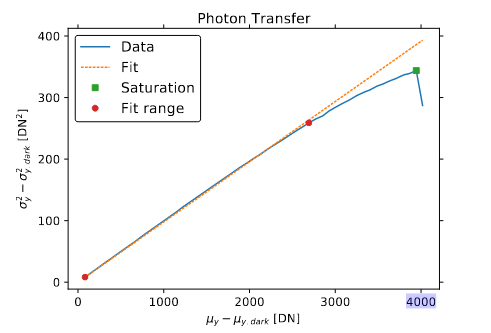

---

### c)

Verwenden Sie die Photonentransfermethode nach EMVA 1288, um eine Sensitivitäts- und eine Photonentransferkurve zu erstellen. Schauen Sie sich dazu die Beispiele inden Vorlesungsunterlagen bzw. in der EMVA 1288 an


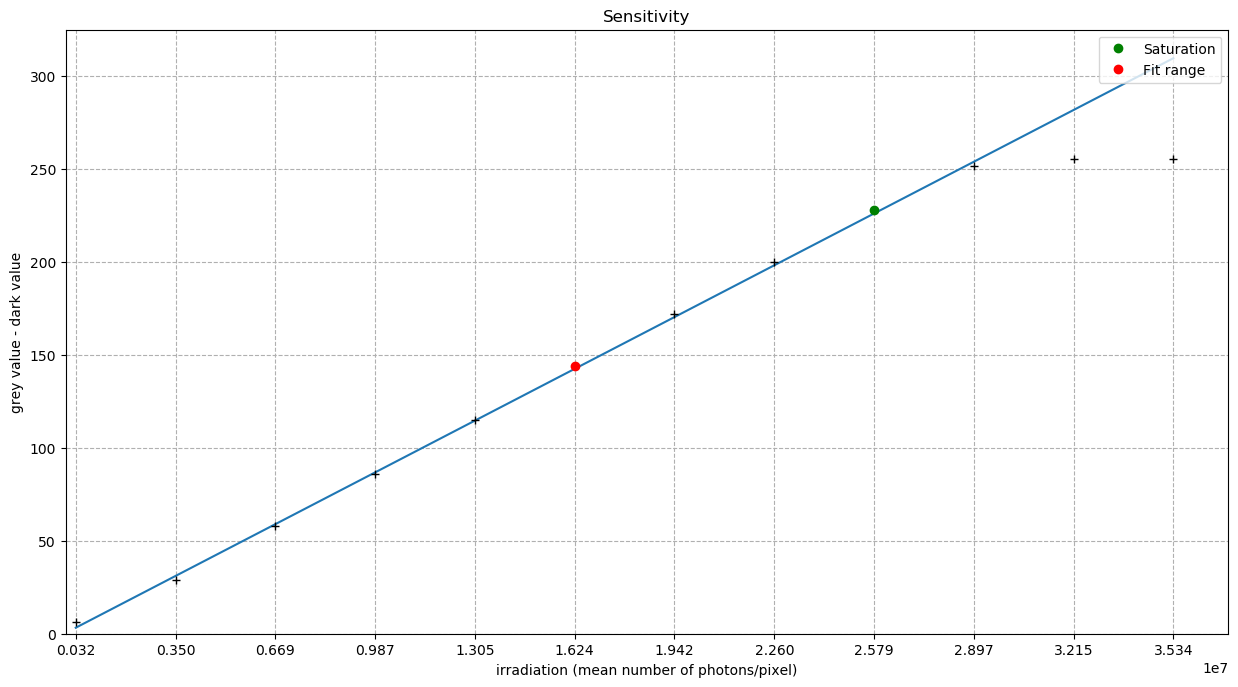

Responsivität R: 8.74E-06
Quanteneffizienz = R/K: 3.48E-04


In [25]:
mg_weiss,zr_weiss = mittlerergauwert(img_weiss_1,img_weiss_2)

#x = np.arange(len(mg_schwa))

# mittlere Anzahl an einfallenden Photonen

x = (Belichtungszeit * 1e-3) * (A * E * LAMBDA * 5.034e24) 
R,b_R = regression(x[i],(mg_weiss-mg_schwa)[i] )
plt.figure(figsize=(15,8),dpi=100,facecolor='w', edgecolor='k')
plt.plot(x,b_R+R*x)
plt.plot(x,mg_weiss,'+',color='black')
plt.xticks(x)
plt.plot(x[i_p],(mg_weiss-mg_schwa)[i_p],'o',color = 'g',label='Saturation')
plt.plot(x[i[0][-1]],(mg_weiss-mg_schwa)[i[0][-1]],'o',color="r",label='Fit range')
plt.ylim(ymin=0)
plt.xlim(xmin=0)
plt.legend(loc='upper right')
plt.ylabel("grey value - dark value")
plt.xlabel("irradiation (mean number of photons/pixel)")
plt.title("Sensitivity")
plt.grid(linestyle="--")
plt.show()
print("Responsivität R: {:.2E}".format(R))
print("Quanteneffizienz = R/K: {:.2E}".format(R/K))

### d) 
Bestimmen Sie die Responsivität R, Kameraverstärkung K, Quanteneffizienz η und
das Dunkelsignal $\sigma^2_d$ , wie in der Vorlesung gezeigt.

$\sigma^2_d = \frac{\sigma^2_{y,dark}-\sigma^2_q}{K^2}$

In [26]:
## ??